In [106]:
import numpy as np
import pandas as pd
import texthero as hero
import os
import nltk
from newspaper import Article
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scattertext as st
import pytextrank
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline


In [107]:
CATEGORY_MAPPINGS = {
    "The Hype": "Concerns & Hype",
    "The Panic": "Concerns & Hype",
    "The good coverage": "Advances & Business",
    "Expert Opinions & Discussion within the field": "Expert Opinions & Discussion within the field",
    "Explainers": "Explainers",
    "AI Advances": "Advances & Business",
    "AI Worries": "Concerns & Hype",
    "Advances & Business": "Advances & Business",
    "Concerns & Hype": "Concerns & Hype",
    "Analysis & Policy": "Analysis & Policy",
    "Mini Briefs": "Mini Briefs"
}

In [108]:
def parse_file(file_name):
    with open(file_name,'r') as f:
        current_category = None
        articles = []
        for line in f:
            for c in CATEGORY_MAPPINGS.keys():
                if c in line:
                    current_category = CATEGORY_MAPPINGS[c]
            if current_category and '[' in line and '(' in line:
                title = line.split('[')[1].split(']')[0]
                url = line.split('(')[1].split(')')[0]
                if len(title.split(' '))<4:
                    continue
                if ' - ' in line:
                    excerpt = line.split(' - ')[1].strip()
                else:
                    excerpt = ''
                article = Article(url)
                try: 
                    article.download()
                    article.parse()
                    authors = article.authors
                    date = article.publish_date
                    text = article.text
                    top_image = article.top_image
                    article.nlp()
                    keywords = article.keywords
                    summary = article.summary
                except:
                    authors=None
                    date=None
                    text=None
                    keywords=[]
                    summary=''
                articles.append([str(current_category), 
                                 title, 
                                 date, 
                                 url, 
                                 excerpt, 
                                 authors, 
                                 keywords, 
                                 summary,
                                 text])
    return articles

In [111]:
all_articles = []
category_counts = {}
for file_name in os.listdir('.'):
    if '.md' not in file_name or 'year' in file_name:
        continue
    name_parts = file_name.split('.')[0].split('-')
    year = int(name_parts[0])
    month = int(name_parts[1])
    day = int(name_parts[2])
    edition = int(name_parts[3])
    articles = parse_file(file_name)
    for article in articles:
        article.insert(0,edition)
    all_articles+=articles
    for article in articles:
        if article[0] not in category_counts:
            category_counts[article[0]]=0
        category_counts[article[0]]+=1

In [112]:
print(len(all_articles))
print(category_counts)

1726
{1: 8, 2: 13, 3: 9, 4: 13, 5: 17, 6: 17, 7: 13, 8: 19, 9: 15, 10: 20, 11: 17, 12: 14, 13: 15, 14: 21, 15: 17, 16: 20, 17: 21, 18: 16, 19: 19, 20: 12, 21: 26, 22: 23, 23: 16, 24: 11, 25: 13, 26: 22, 27: 26, 28: 13, 29: 16, 30: 31, 31: 27, 32: 35, 33: 20, 34: 17, 35: 18, 36: 19, 37: 26, 38: 14, 39: 23, 40: 30, 41: 23, 42: 11, 43: 31, 44: 27, 45: 25, 46: 16, 47: 17, 48: 24, 49: 39, 50: 26, 51: 26, 52: 24, 53: 25, 54: 23, 55: 16, 56: 16, 57: 22, 58: 15, 59: 20, 60: 13, 61: 12, 62: 9, 63: 13, 64: 11, 65: 17, 66: 12, 67: 16, 68: 13, 69: 17, 70: 18, 71: 12, 72: 16, 73: 18, 74: 13, 75: 14, 76: 12, 77: 35, 78: 25, 79: 17, 80: 17, 81: 14, 82: 20, 83: 22, 84: 22, 85: 21, 86: 14, 87: 15, 88: 31, 89: 27, 90: 21, 91: 21}


In [113]:
df = pd.DataFrame(all_articles, columns =['edition', 'category', 'title', 'date', 'url', 'excerpt', 'authors', 'keywords', 'summary', 'text']) 

In [114]:
categories = df['category'].unique()

In [116]:
cfd = nltk.ConditionalFreqDist(
    (article[1], word.lower())
    for article in all_articles
    for word in nltk.tokenize.word_tokenize(article[2]))
modals = ['ai',
 'bias',
 'neural',
 'robot',
 'artificial',
 'facial']
cfd.tabulate(categories, samples=modals)

                                                      ai       bias     neural      robot artificial     facial 
                          Advances & Business        286          6         17         36         65         10 
                            Analysis & Policy         86          4          0          3         33         14 
                              Concerns & Hype        192         18          3         10         25         56 
Expert Opinions & Discussion within the field         80          3          1          3         18          1 
                                   Explainers         41          4          8          2          6          1 
                                  Mini Briefs         71          4          1          5         13          6 


In [148]:
cfd = nltk.ConditionalFreqDist(
    (article[0], word.lower())
    for article in all_articles
    for word in nltk.tokenize.word_tokenize(article[2]))

def plot_trends(words, synonyms={}):
    dicts = []
    X = list(range(1,91))
    word_totals = {word:0 for word in words}
    for x in X:
        word_counts = cfd[x]
        d = {'edition': x}

        for word in words:
            word_key = word
            if word in synonyms:
                word_key = synonyms[word]
            word_totals[word_key]+=word_counts[word]
            d[word_key] = word_totals[word_key]
        dicts.append(d)
    df_plot = pd.DataFrame(dicts)
    df_plot.plot(x='edition')

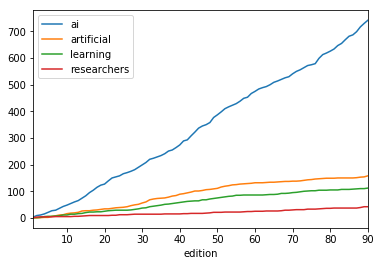

In [159]:
plot_trends(['ai', 'researchers', 'learning', 'artificial'], {'learned': 'learning', 'research':'researchers'})

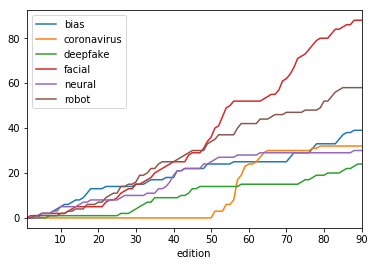

In [161]:
words = ['bias', 'neural', 'robot', 'facial', 'coronavirus',  'deepfake']
synonyms = {'covid-19':'coronavirus', 'covid':'coronavirus', 'deepfakes':'deepfake'}
plot_trends(words, synonyms)

In [66]:
df['pca'] = (
   df['text']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)
hero.scatterplot(df, 'pca', color='category', title="AI News")

In [67]:
df['pca'] = (
   df['keywords']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)
hero.scatterplot(df, 'pca', color='category', title="AI News")

In [68]:
df['pca'] = (
   df['excerpt']
   .pipe(hero.clean)
   .pipe(hero.tfidf)
   .pipe(hero.pca)
)
hero.scatterplot(df, 'pca', color='category', title="AI News")

In [87]:
nlp = spacy.load('en')
corpus = st.CorpusFromPandas(df, 
                              category_col='category', 
                              text_col='text',
                              nlp=nlp).build().compact(st.AssociationCompactor(2500))

In [89]:
print('Top common words:')
pprint(list(corpus.get_scaled_f_scores_vs_background().index[:25]))

Top common words:
['ai',
 'openai',
 'facebook',
 'clearview',
 'deepmind',
 'twitter',
 'deepfakes',
 'waymo',
 'deepfake',
 'neural',
 'robots',
 'algorithmic',
 'imagenet',
 'youtube',
 'artificial',
 'coronavirus',
 'algorithms',
 'autonomous',
 'robotics',
 'datasets',
 'buzzfeed',
 'dataset',
 'adversarial',
 'facial',
 'lecun']


In [71]:
def make_cat_explorer(cat):
    html = st.produce_scattertext_explorer(corpus,
              category=cat,
              category_name=cat,
              not_category_name='Other',
              width_in_pixels=1000,)
    open("scatterplots/%s Viz.html"%cat, 'wb').write(html.encode('utf-8'))

In [72]:
for cat in categories:
    make_cat_explorer(cat)

In [76]:
def make_word_cloud(cat=None):
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for article in all_articles: 
        if cat is not None and article[0]!=cat:
            continue
        val = article[1]
        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show() 

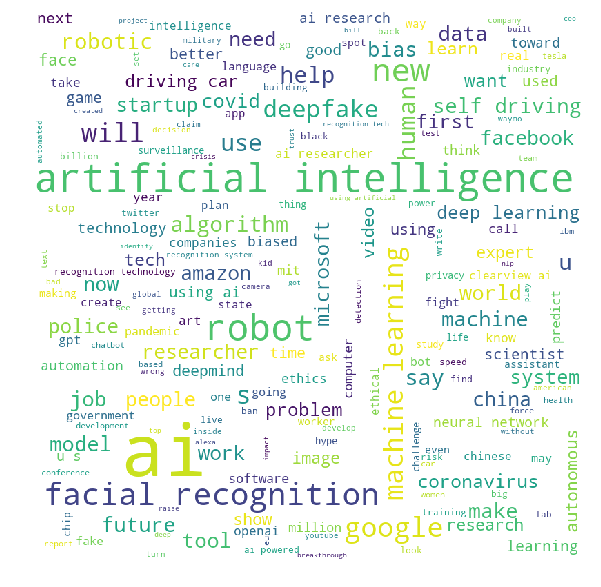

In [77]:
make_word_cloud(None)